In [ ]:
import pandas as pd

sparkDF = spark.sql("SELECT * FROM bronze_lakehouse.green_tripdata_2017 LIMIT 1000")
display(sparkDF)


StatementMeta(, cee8030a-c170-48dc-94bc-e704ef5d87be, 3, Finished, Available, Finished)

SynapseWidget(Synapse.DataFrame, 3d5ff61e-525b-4453-bb62-edec231a6c4a)

In [ ]:
sparkDF.printSchema()

StatementMeta(, cee8030a-c170-48dc-94bc-e704ef5d87be, 5, Finished, Available, Finished)

root
 |-- VendorID: long (nullable = true)
 |-- lpep_pickup_datetime: timestamp (nullable = true)
 |-- lpep_dropoff_datetime: timestamp (nullable = true)
 |-- store_and_fwd_flag: string (nullable = true)
 |-- RatecodeID: long (nullable = true)
 |-- PULocationID: long (nullable = true)
 |-- DOLocationID: long (nullable = true)
 |-- passenger_count: long (nullable = true)
 |-- trip_distance: double (nullable = true)
 |-- fare_amount: double (nullable = true)
 |-- extra: double (nullable = true)
 |-- mta_tax: double (nullable = true)
 |-- tip_amount: double (nullable = true)
 |-- tolls_amount: double (nullable = true)
 |-- ehail_fee: double (nullable = true)
 |-- improvement_surcharge: double (nullable = true)
 |-- total_amount: double (nullable = true)
 |-- payment_type: long (nullable = true)
 |-- trip_type: long (nullable = true)
 |-- congestion_surcharge: double (nullable = true)
 |-- source_file: string (nullable = true)



In [ ]:
# Filter the dataset 
from pyspark.sql.functions import *
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
filtered_df = sparkDF.select('VendorID', 'passenger_count', 'trip_distance','payment_type', 'fare_amount', 'tip_amount'\
                                , date_format('lpep_pickup_datetime', 'hh').alias('hour_of_day')\
                                , dayofweek('lpep_pickup_datetime').alias('day_of_week')\
                                , dayofmonth(col('lpep_pickup_datetime')).alias('day_of_month'))\
                            .filter((sparkDF.passenger_count > 0)\
                                & (sparkDF.fare_amount >= 1) & (sparkDF.fare_amount <= 250)\
                                & (sparkDF.trip_distance > 0) & (sparkDF.trip_distance <= 200))

filtered_df.createOrReplaceTempView("taxi_dataset")
filtered_df.head()

StatementMeta(, cee8030a-c170-48dc-94bc-e704ef5d87be, 19, Finished, Available, Finished)

Row(VendorID=2, passenger_count=2, trip_distance=12.43, payment_type=2, fare_amount=52.0, tip_amount=0.0, hour_of_day='04', day_of_week=5, day_of_month=18)

In [ ]:
%%sql
SELECT 
    day_of_month
    , AVG(fare_amount) AS avgTipAmount
    , AVG(fare_amount) as fareAmount
FROM taxi_dataset 
GROUP BY day_of_month
ORDER BY day_of_month ASC

StatementMeta(, cee8030a-c170-48dc-94bc-e704ef5d87be, 20, Finished, Available, Finished)

<Spark SQL result set with 31 rows and 3 fields>

In [ ]:
# # To make development easier, faster, and less expensive, downsample for now
# sampled_taxi_df = filtered_df.sample(True, 0.001, seed=1234)

# The charting package needs a Pandas DataFrame or NumPy array to do the conversion
sampled_taxi_pd_df = filtered_df.toPandas()
sampled_taxi_pd_df

StatementMeta(, cee8030a-c170-48dc-94bc-e704ef5d87be, 21, Finished, Available, Finished)

,VendorID,passenger_count,trip_distance,payment_type,fare_amount,tip_amount,hour_of_day,day_of_week,day_of_month
0,2,2,12.43,2,52.0,0.0,04,5,18
1,1,2,16.90,2,52.0,0.0,06,6,1
2,1,4,14.80,2,73.0,0.0,12,6,23
3,2,5,16.07,2,81.5,0.0,05,6,3
4,2,2,20.13,1,105.0,0.0,04,2,15
...,...,...,...,...,...,...,...,...,...
960,2,2,9.76,2,28.5,0.0,02,6,24
961,2,2,25.95,2,68.5,0.0,06,7,25
962,2,2,6.14,2,20.5,0.0,12,1,1
963,2,2,6.04,2,21.5,0.0,09,6,27


StatementMeta(, cee8030a-c170-48dc-94bc-e704ef5d87be, 22, Finished, Available, Finished)

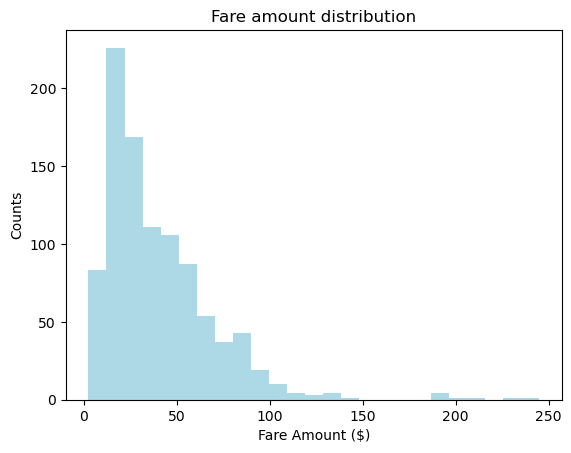

In [ ]:
# Look at a histogram of tips by count by using Matplotlib

ax1 = sampled_taxi_pd_df['fare_amount'].plot(kind='hist', bins=25, facecolor='lightblue')
ax1.set_title('Fare amount distribution')
ax1.set_xlabel('Fare Amount ($)')
ax1.set_ylabel('Counts')
plt.suptitle('')
plt.show()

StatementMeta(, cee8030a-c170-48dc-94bc-e704ef5d87be, 23, Finished, Available, Finished)

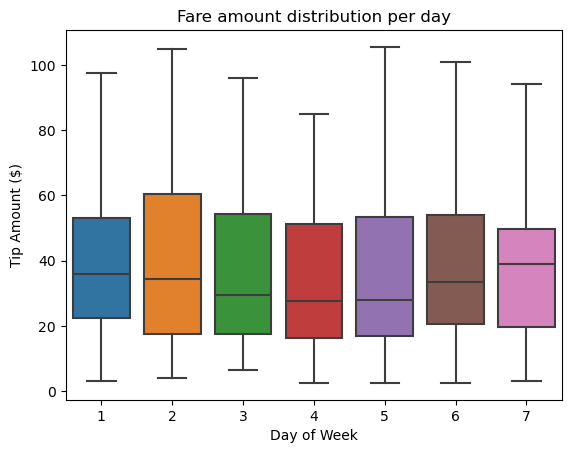

In [ ]:
# View the distribution of tips by day of week using Seaborn
ax = sns.boxplot(x="day_of_week", y="fare_amount",data=sampled_taxi_pd_df, showfliers = False)
ax.set_title('Fare amount distribution per day')
ax.set_xlabel('Day of Week')
ax.set_ylabel('Tip Amount ($)')
plt.show()

StatementMeta(, cee8030a-c170-48dc-94bc-e704ef5d87be, 24, Finished, Available, Finished)

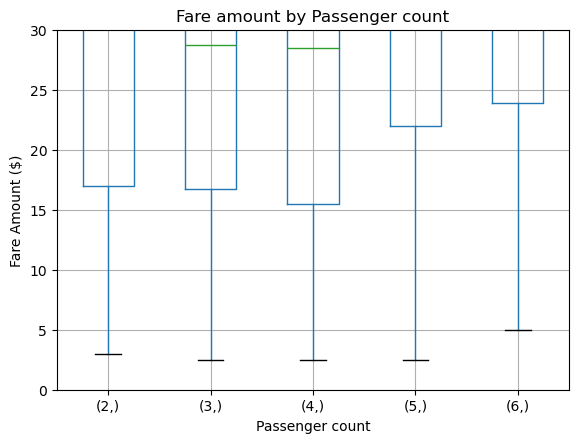

In [ ]:
# How many passengers tipped by various amounts 
ax2 = sampled_taxi_pd_df.boxplot(column=['fare_amount'], by=['passenger_count'])
ax2.set_title('Fare amount by Passenger count')
ax2.set_xlabel('Passenger count')
ax2.set_ylabel('Fare Amount ($)')
ax2.set_ylim(0,30)
plt.suptitle('')
plt.show()

StatementMeta(, cee8030a-c170-48dc-94bc-e704ef5d87be, 25, Finished, Available, Finished)

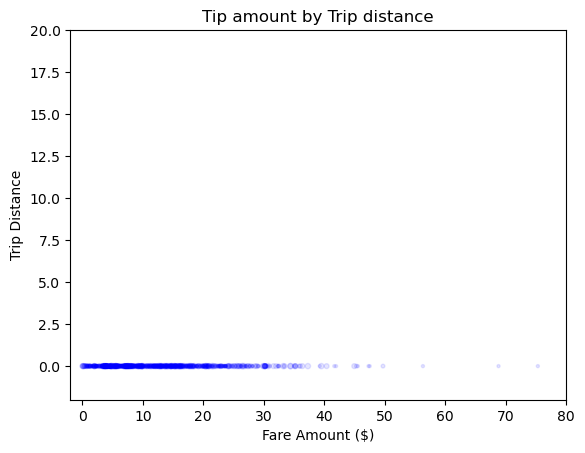

In [ ]:
# Look at the relationship between fare and tip amounts

ax = sampled_taxi_pd_df.plot(kind='scatter', x= 'trip_distance', y = 'tip_amount', c='blue', alpha = 0.10, s=2.5*(sampled_taxi_pd_df['passenger_count']))
ax.set_title('Tip amount by Trip distance')
ax.set_xlabel('Fare Amount ($)')
ax.set_ylabel('Trip Distance')
plt.axis([-2, 80, -2, 20])
plt.suptitle('')
plt.show()